In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
from scipy.stats import circvar, circmean, circstd
import brokenaxes

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

import sac_mode_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
%matplotlib widget
plt.rcParams.update({"figure.max_open_warning": 0, "mathtext.default": "regular"})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"
exts = [".png", ".svg"]

In [4]:
titration_mode = "ach"
titr_lbl = "ACh" if titration_mode == "ach" else "GABA" if titration_mode == "gaba" else "Titration"
factor_xlbl = "ACh Pr factor" if titration_mode == "ach" else "$g_{%s}$ factor" % titr_lbl
titration_path = os.path.join(base_path, "%s_titration" % titration_mode)
fig_path = os.path.join(base_path, "multiplex_%s_titration_figs" % titration_mode)
fig_subdir = None
# exp_names = {
#     "ctrl": "ctrl_5ms_step_weight_x2_order2_6n_3tr_0p0_5p0",
#     "plex1": "plex1_5ms_step_weight_x2_sac_30um_6n_3tr_0p0_5p0",
#     "plex2": "plex2_5ms_step_weight_x2_sac_30um_6n_3tr_0p0_5p0",
#     "plex3": "plex3_5ms_step_weight_x2_order2_6n_3tr_0p0_5p0",
#     "plex4": "plex4_5ms_step_weight_x2_sac_30um_6n_3tr_0p0_5p0",
# }
# exp_names = {
#     "ctrl": "ctrl_etau3_x2p0w_itau6_x4p0w_6n_3tr_0p0_5p0",
#     "plex3": "plex3_etau3_x2p0w_itau6_x4p0w_6n_3tr_0p0_5p0",
#     "plex4": "plex4_etau3_x2p0w_itau6_x4p0w_6n_3tr_0p0_5p0",
# }
# exp_names = {
    # "ctrl": "poissarma_etau3_x0p6w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_6n_3tr_0p0_5p0",
    # "plex3": "poissarma_etau3_x0p6w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_6n_3tr_0p0_5p0_plex3",
    # "plex4": "poissarma_etau3_x0p6w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_6n_3tr_0p0_5p0_plex4",
    # "plex5": "poissarma_etau3_x0p6w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_6n_3tr_0p0_5p0_plex5",
# }
# exp_names = {
#     "ctrl": "poissarma_etau3_x0p6w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_6n_3tr_0p0_5p0",
#     "plex4": "poissarma_etau3_x0p6w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_6n_3tr_0p0_5p0_plex4",
# }
fig_subdir, exp_names = ("uncorr_plex", {
    "ctrl": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0",
    "plex1": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0_plex1",
    "plex2": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0_plex2",
    "plex3": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0_plex3",
    "plex4": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0_plex4",
})
# exp_names = {
#     "ctrl": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho98_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0",
#     "plex4": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho98_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0_plex4",
# }
# exp_names = {
#     "rho8": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho8_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0",
#     "rho9": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho9_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0",
#     "rho95": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0",
#     "rho98": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho98_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0",
# }
# exp_names = {
#     "ctrl": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0",
#     "100um": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_100um_rate1p5_6n_3tr_0p0_5p0",
# }
# exp_names = {
#     "ctrl": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0",
#     "nocorr": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho0_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0",
#     "flatcorr": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95flat_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0",
# }
# fig_subdir, exp_names = ("corr_vs_uncorr_plex4", {
#     "ctrl": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0_corrctrl",
#     "plex4": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0_corrplex4",
#     "ctrl_uncorr": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0_uncorrctrl",
#     "plex4_uncorr": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0_uncorrplex4",
# })
fig_subdir, exp_names = ("plex_syn_mode", {
    "ctrl": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0_corrctrl",
    "plex4": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0_corrplex4",
    "plex4_pref": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0_corrplex4_onlyp",
    "plex4_null": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_6n_3tr_0p0_5p0_corrplex4_onlyn",
})
fig_subdir, exp_names = ("ctrl_vs_plex_9n_5tr", {
    "ctrl": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0",
    "plex3": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_corrplex3",
    "plex4": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_corrplex4",
    "plex5": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_corrplex5",
})
fig_subdir, exp_names = ("ctrl_vs_plex_9n_5tr_reset", {
    "ctrl": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_reset",
    "plex2": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_corrplex2_reset",
    "plex3": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_corrplex3_reset",
    "plex4": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_corrplex4_reset",
    "plex5": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_corrplex5_reset",
})
fig_subdir, exp_names = ("ctrl_vs_plex_rho100_9n_5tr_reset", {
    "ctrl": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_reset",
    "plex4": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_corrplex4_reset",
})
fig_subdir, exp_names = ("ctrl_vs_plex_modes_rho100_9n_5tr_reset", {
    "ctrl": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_reset",
    "plex4": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_corrplex4_reset",
    "plex4_onlyp": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_corrplex4_onlyp_reset",
    "plex4_onlyn": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_corrplex4_onlyn_reset",
})
fig_subdir, exp_names = ("ctrl_vs_multi_plex_rho100_9n_5tr_reset", {
    "ctrl": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_reset",
    "plex1": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_corrplex1_reset",
    "plex2": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_corrplex2_reset",
    "plex3": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_corrplex3_reset",
    "plex4": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_9n_5tr_0p0_5p0_corrplex4_reset",
})
fig_subdir, exp_names = ("ctrl_vs_plex_rho100_9n_5tr_ach", {
    "ctrl": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_9n_5tr_1p0_5p0",
    # "plex1": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_9n_5tr_1p0_5p0_corrplex1",
    "plex4": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho100_er1p2_ir0p6_nr1p2_9n_5tr_1p0_5p0_corrplex4",
})

fig_path = fig_path if fig_subdir is None else os.path.join(fig_path, fig_subdir)
exp_hdfs = {k: h5.File(os.path.join(titration_path, n) + ".h5", "r") for k, n in exp_names.items()}
d = {k: Workspace(hdf, read_only=True) for k, hdf in exp_hdfs.items()}
os.makedirs(fig_path, exist_ok=True)

exps = list(d.keys())
ctrl_lbl = exps[0]
expr_lbl = exps[-1]
# ctrl_lbl = "ctrl"
# expr_lbl = "plex3"
ctrl = d[ctrl_lbl]
expr = d[expr_lbl]

factors = list(ctrl.keys())
rhos = list(ctrl[factors[0]].keys())
idxs = sorted(ctrl[factors[0]][rhos[0]].keys())
print("titration_mode:", titration_mode)
print("==keys==")
print("exps:", exps)
print("factors:", factors)
print("rhos:", rhos)
print("idxs:", idxs)

titration_mode: ach
==keys==
exps: ['ctrl', 'plex4']
factors: [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 1.9, 2.0, 3.0, 4.0, 5.0]
rhos: [0.0, 1.0]
idxs: [0, 1, 2, 3, 4, 5, 6, 7, 8]


In [5]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            for wrk in d.values():
                wrk.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [6]:
params = d[ctrl_lbl][1.0][1.0][0]["params"]
xaxis = np.arange(int(params["tstop"] / params["dt"]) + 1) * params["dt"]
metrics = {exp: {k: ana.get_sac_metrics(wrk[k]) for k in factors} for exp, wrk in d.items()}

dir_labels = d[ctrl_lbl][factors[0]][rhos[0]][idxs[0]]["params"]["dir_labels"][:]
sac_thetas = {exp: ana.get_sac_thetas(wrk[factors[0]]) for exp, wrk in d.items()}
sac_deltas = {exp: ana.get_sac_deltas(ts) for exp, ts in sac_thetas.items()} 
print("metrics:", list(metrics[ctrl_lbl][factors[0]][rhos[0]].keys()))

metrics: ['spikes', 'thetas', 'DSis', 'avg_theta', 'avg_DSi']


In [7]:
soma_vm = {
    exp: {
       factor: {
           rho: np.stack([d[exp][factor][rho][net]["soma"]["Vm"] for net in idxs], axis=0)
           for rho in rhos
        }
        for factor in factors
    } 
    for exp in exps
}

In [8]:
calc_rates = False
calc_rate_exn = ValueError("Cannot use rate_mode when rates have not been calculated (calc_rates = False)")
def assert_calc_rates(): 
    if not calc_rates: raise calc_rate_exn
if calc_rates:
    spike_rates = map_data(lambda vm: spike_transform(vm, 3000, 50), soma_vm)
    net_avg_spike_rates = map_data(lambda r: r.mean(axis=1), spike_rates)
    net_peak_spike_rates = map_data(lambda r: r.max(axis=-1), net_avg_spike_rates)

In [9]:
if calc_rates:
    st = np.mean(spike_rates[ctrl_lbl][1.0][1.0], axis=(0, 1)) 
    ex_rate_fig, ex_rate_ax = plt.subplots(1)
    ex_rate_ax_right = ex_rate_ax.twinx()
    ex_rate_ax.plot(xaxis, d[ctrl_lbl][1.0][1.0][0]["soma"]["Vm"][0, 3], c="black")
    ex_rate_ax_right.plot(xaxis, st[3] * 100)
    ex_rate_ax.set_ylabel("mV")
    ex_rate_ax_right.set_ylabel("Spike Rate (Hz)")
    ex_rate_ax.set_xlabel("Time (ms)")

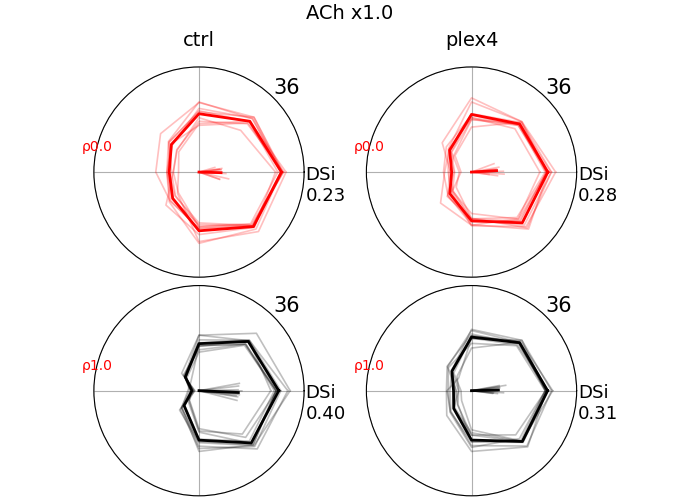

In [10]:
display_exps = exps
# display_exps = ["ctrl"]
# display_exps = ["ctrl", "plex4"]
display_rhos = rhos
# display_rhos = [1.0]
factor = 1.
rate_mode = False

if len(display_rhos) <= 2:
    colours = ["red", "black"]
else:
    colours = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8"]

if rate_mode and assert_calc_rates():
    max_spikes = np.max([np.max(r) for ex in net_peak_spike_rates.values() for r in ex[factor].values()])
else:
    max_spikes = np.max([r["spikes"] for ms in metrics.values() for r in ms[factor].values()])
    
focus_polar_fig = plt.figure(figsize=(7, 5))
max_rows = 5
n_rows = min(max_rows, len(display_rhos))
splits = int(np.ceil(len(display_rhos) / max_rows))
n_cols = len(display_exps) * splits
focus_polar_ax = []
for i, rho in enumerate(display_rhos):
    row = i % max_rows
    subcol = i // max_rows
    for j, exp in enumerate(display_exps):
        focus_polar_ax.append(polar(
            (metrics[exp][factor][rho]["spikes"]
             if not rate_mode 
             else net_peak_spike_rates[exp][factor][rho].reshape(len(idxs), 1, 8)),
            dir_labels,
            title=None,
            # radius=max_spikes,
            radius=36,
            net_shadows=True,
            fig=focus_polar_fig,
            sub_loc=(n_rows, n_cols, (row * n_cols + j * splits + subcol + 1)),
            title_metrics=False,
            avg_colour=colours[i],
            shadow_alpha=0.25,
            shadow_linewidth=1.2,
        ))
        focus_polar_ax[-1].text(np.radians(170), max_spikes * 1.2, ("ρ" + str(rho)), c="red")

for i, exp in enumerate(display_exps):
    focus_polar_ax[i * splits].set_title(exp, fontsize=14, pad=15)
    
rhos_lbl = "many_rhos" if len(display_rhos) > 4 else "_".join(map(str, display_rhos)).replace(".", "p")
focus_polar_fig.suptitle("%s x%.1f" % (titr_lbl, factor), fontsize=14)
focus_polar_fig.set_layout_engine("compressed")
for ext in [".svg", ".png"]:
    focus_polar_fig.savefig(
        os.path.join(fig_path, "%s_x%.1f_rhos%s_polars%s" % (titration_mode, factor, rhos_lbl, ext)),
        bbox_inches="tight")

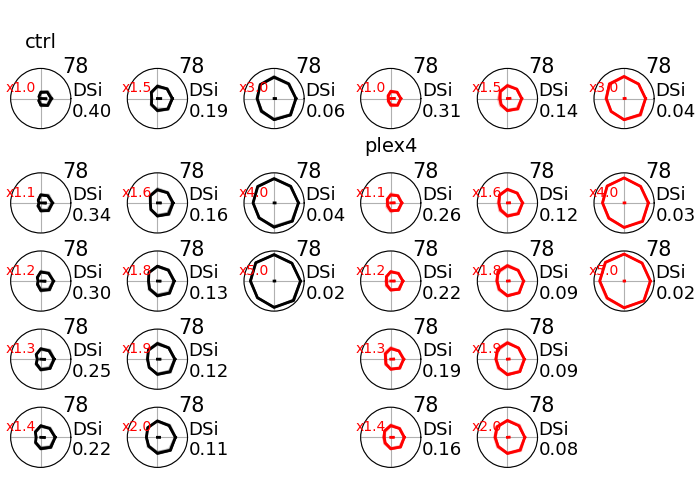

In [11]:
rho = 1.0
display_exps = exps
# display_exps = ["ctrl", "plex4"]
# display_exps = ["ctrl"]
display_factors = factors
# display_factors = [0.4, 0.6, 0.8, 1.0]
# display_factors = [0.6, 0.8, 1.0, 1.2, 1.4]
# display_factors = [0.8, 1.0, 1.2, 1.4]
# display_factors = [0.6, 1.0, 1.4]
# display_factors = [0.1, 0.2, 0.4, 0.6]
# display_factors = [1.0, 2.0, 3.0]
rate_mode = False

if len(display_exps) <= 2:
    colours = ["black", "red"]
else:
    colours = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8"]
    
if rate_mode and assert_calc_rates():
    max_spikes = np.max(
        [np.max(r) for ex in net_peak_spike_rates.values() for f in display_factors for r in ex[f].values()])
else:
    max_spikes = np.max(
        [r["spikes"] for exp in display_exps for s in display_factors for r in metrics[exp][s].values()])
    
polar_fig = plt.figure(figsize=(7, 5))
max_rows = 5
n_rows = min(max_rows, len(display_factors))
splits = int(np.ceil(len(display_factors) / max_rows))
n_cols = len(display_exps) * splits
polar_ax = []
for i, factor in enumerate(display_factors):
    row = i % max_rows
    subcol = i // max_rows
    for j, exp in enumerate(display_exps):
        polar_ax.append(polar(
            (metrics[exp][factor][rho]["spikes"] 
             if not rate_mode 
             else net_avg_spike_rates[exp][factor][rho].max(axis=-1).reshape(len(idxs), 1, 8)),
            dir_labels,
            title=None,
            title_metrics=False,
            radius=max_spikes,
            net_shadows=True,
            fig=polar_fig,
            sub_loc=(n_rows, n_cols, (row * n_cols + j * splits + subcol + 1)),
            dsi_tag_deg=-30,
            dsi_tag_mult=1.2,
            avg_colour=colours[j],
            shadow_alpha=0.25,
            shadow_linewidth=1.2,
        ))
        polar_ax[-1].text(np.radians(170), max_spikes * 1.2, ("x" + str(factor)), c="red")

for i, exp in enumerate(display_exps):
    polar_ax[i * splits].set_title(exp, fontsize=14, pad=15)

polar_fig.set_layout_engine("compressed")
exps_lbl = "_".join(display_exps)
rho_lbl = str(rho).replace(".", "p")
factors_lbl = "many_factors" if len(display_factors) > 4 else "_".join(map(str, display_factors)).replace(".", "p")
rate_lbl = "_peakrate" if rate_mode else "" 
for ext in exts:
    polar_fig.savefig(
        os.path.join(fig_path, "polar_grid_%s_titration_%s_%s_%s%s%s" % (
            titration_mode, exps_lbl, rho_lbl, factors_lbl, rate_lbl, ext)),
        bbox_inches="tight"
    )

plex4 1.0 matching DSi of ctrl 1.0 requires ~0.8050049067713441x ACh


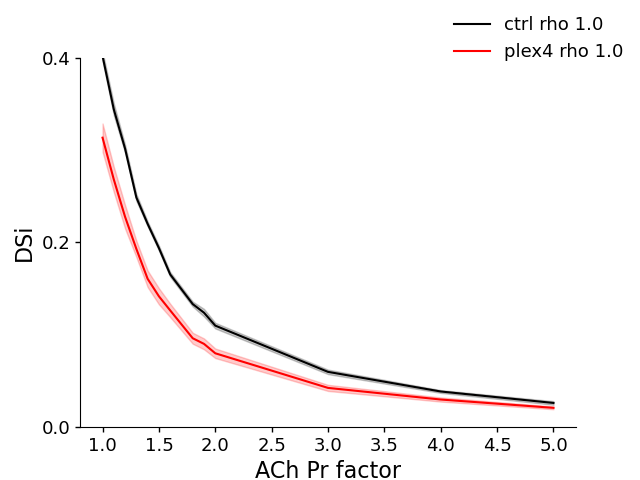

In [32]:
display_exps = exps
# display_exps = ["ctrl", "plex3"]
# display_exps = ["ctrl", "plex4"]
# display_exps = ["ctrl"]
# display_exps = ["plex4"]
# display_exps = ["plex4", "plex4_uncorr"]
display_rhos = rhos
display_rhos = [1.0]
# display_rhos = [0.0]
rate_mode = False
rho_colour_mode = True
sem_mode = True


if len(display_exps) == 1 and len(display_rhos) == 2:
    colours = ["red", "black"]
    rho_linestyles = {0.0: "-", 1.0: "-"}
    rho_hatches = {0.0: None, 1.0: None}
elif len(display_exps) == 2 and len(display_rhos) == 1:
    colours = ["black", "red"]
    rho_linestyles = {0.0: "-", 1.0: "-"}
    rho_hatches = {0.0: None, 1.0: None}
else:
    colours = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8"]
    rho_linestyles = {0.0: "--", 1.0: "-"}
    rho_hatches = {0.0: "o", 1.0: None}
rho_colour_mode = False if len(display_rhos) == 1 else rho_colour_mode

dsi_fig, dsi_ax = plt.subplots(1)
titration = {"dsi": {}, "theta": {}, "abstheta": {}, "thetavar": {}, "absnettheta": {}, "circvar": {}}
colour_idx = 0
n_sqrt = np.sqrt(len(idxs))
err_key = "sem" if sem_mode else "std"
for exp in exps:
    for k in titration.keys():
        titration[k][exp] = {}
    for rho in rhos:
        for k in titration.keys():
            titration[k][exp][rho] = {"nets": [], "avg": [], "std": [], "sem": []}
        titration["theta"][exp][rho]["net_circvar"] = []
        titration["theta"][exp][rho]["all_circvar"] = []
        for factor in factors:
            net_mets = {}
            if rate_mode and assert_calc_rates():
                dsi_net_avgs, _ = calc_tuning(net_peak_spike_rates[exp][factor][rho].T, dir_labels)
                net_mets["dsi"] = dsi_net_avgs
            else:
                net_mets["dsi"] = metrics[exp][factor][rho]["DSis"].mean(axis=1)
            thetas = metrics[exp][factor][rho]["thetas"]
            net_mets["theta"] = scale_180_from_360(np.degrees(circmean(np.radians(thetas), axis=1)))
            net_mets["abstheta"] = np.abs(thetas).mean(axis=1)
            net_mets["thetavar"] = np.var(thetas, axis=1)
            net_mets["absnettheta"] = np.abs(net_mets["theta"])
            net_mets["circvar"] = circvar(np.radians(thetas), axis=1)
            for (k, ns) in net_mets.items():
                titration[k][exp][rho]["nets"].append(ns)
                if k == "theta":
                    titration[k][exp][rho]["avg"].append(
                        scale_180_from_360(np.degrees(circmean(np.radians(ns)))))
                    titration[k][exp][rho]["std"].append(
                        scale_180_from_360(np.degrees(circstd(np.radians(ns)))))
                else:
                    titration[k][exp][rho]["avg"].append(np.mean(ns))
                    titration[k][exp][rho]["std"].append(np.std(ns))
                titration[k][exp][rho]["sem"].append(titration[k][exp][rho]["std"][-1] / n_sqrt)
            titration["theta"][exp][rho]["net_circvar"].append(circvar(np.radians(net_mets["theta"])))
            titration["theta"][exp][rho]["all_circvar"].append(circvar(np.radians(thetas)))
        for k in titration.keys():
            titration[k][exp][rho] = {m: np.array(v) for m, v in titration[k][exp][rho].items()}
            titration[k][exp][rho]["nets"] = titration[k][exp][rho]["nets"].T
        if exp in display_exps and rho in display_rhos:
            dsi_ax.fill_between(
                factors, 
                titration["dsi"][exp][rho]["avg"] + titration["dsi"][exp][rho][err_key],
                titration["dsi"][exp][rho]["avg"] - titration["dsi"][exp][rho][err_key],
                color=colours[colour_idx],
                alpha=0.2,
                hatch=rho_hatches[rho]
            )
            dsi_ax.plot(
                factors,
                titration["dsi"][exp][rho]["avg"],
                color=colours[colour_idx],
                linestyle=rho_linestyles[rho],
                label="%s rho %s" % (exp, str(rho)),
            )
        if rho_colour_mode and exp in display_exps and rho in display_rhos:
            colour_idx += 1
    if not rho_colour_mode and exp in display_exps:
        colour_idx += 1
        
dsi_ax.set_ylabel("DSi", fontsize=16)
dsi_ax.set_xlabel(factor_xlbl, fontsize=16)

if titration_mode == "gaba":
    # dsi_ax.set_xscale("log")
    dsi_ax.set_ylim(0, 0.8)
    dsi_ax.set_yticks([0, 0.4, 0.8])
elif titration_mode == "ach":
    dsi_ax.set_ylim(0, 0.4)
    dsi_ax.set_yticks([0, 0.2, 0.4])

dsi_fig.legend(frameon=False, fontsize=13)
clean_axes(dsi_ax, ticksize=13)

base_lbl = None
if len(display_exps) == 1 and len(display_rhos) == 2:
    base_titr = titration["dsi"][display_exps[0]][display_rhos[1]]["avg"]
    alt_titr = titration["dsi"][display_exps[0]][display_rhos[0]]["avg"]
    alt_lbl, base_lbl = ("%s %s" % (display_exps[0], str(r)) for r in display_rhos)
elif len(display_exps) == 2 and len(display_rhos) == 1:
    base_titr = titration["dsi"][display_exps[0]][display_rhos[0]]["avg"]
    alt_titr = titration["dsi"][display_exps[1]][display_rhos[0]]["avg"]
    base_lbl, alt_lbl = ("%s %s" % (e, str(display_rhos[0])) for e in display_exps)
if base_lbl is not None:
    base_val = base_titr[nearest_index(np.array(factors), 1.0)]
    alt_idx = nearest_index(alt_titr, base_val)
    if alt_titr[alt_idx] == base_val:
        mult = factors[alt_idx]
    else:
        bound_idx = alt_idx + (1 if alt_titr[alt_idx] < base_val else -1)
        i0, i1 = (alt_idx, bound_idx) if alt_idx < bound_idx else (bound_idx, alt_idx) 
        pos = (base_val - alt_titr[i0]) / (alt_titr[i1] - alt_titr[i0])
        mult = pos * (factors[i1] - factors[i0]) + factors[i0]
    print("%s matching DSi of %s requires ~%sx %s" % (alt_lbl, base_lbl, mult, titr_lbl))
    

exps_lbl = "_".join(display_exps)
rhos_lbl = "_".join(map(str, display_rhos)).replace(".", "p")
rate_lbl = "_peakrate" if rate_mode else "" 
for ext in exts:
    dsi_fig.savefig(
        os.path.join(fig_path, "dsi_vs_%s_factor_%s_rhos_%s%s%s" % (
            titration_mode, exps_lbl, rhos_lbl, rate_lbl, ext)),
        bbox_inches="tight",
    )

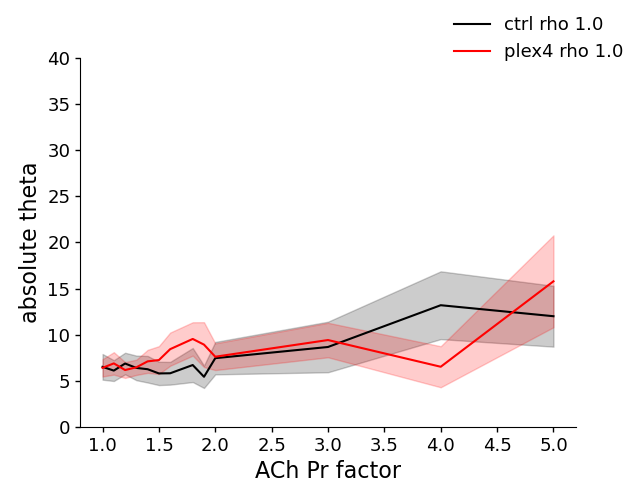

In [33]:
# abs_key = "abstheta" # absolute value of trial thetas then averaged by net
abs_key = "absnettheta"  # absolute value of signed net avgs
abstheta_fig, abstheta_ax = plt.subplots(1)
# abstheta_fig = plt.figure()
# abstheta_ax = brokenaxes.brokenaxes(
#     ylims=((0, 30), (100, 120)),
#     height_ratios=(0.2, 0.8),
#     fig=abstheta_fig,
# )
colour_idx = 0
for exp in display_exps:
    for rho in display_rhos:
        abstheta_ax.fill_between(
            factors, 
            titration[abs_key][exp][rho]["avg"] + titration[abs_key][exp][rho][err_key],
            titration[abs_key][exp][rho]["avg"] - titration[abs_key][exp][rho][err_key],
            color=colours[colour_idx],
            alpha=0.2,
            hatch=rho_hatches[rho]
        )
        abstheta_ax.plot(
            factors,
            titration[abs_key][exp][rho]["avg"],
            color=colours[colour_idx],
            linestyle=rho_linestyles[rho],
            label="%s rho %s" % (exp, str(rho)),
        )
        if rho_colour_mode:
            colour_idx += 1
    if not rho_colour_mode:
        colour_idx += 1
        
abstheta_ax.set_ylim(0, 40)
abstheta_ax.set_ylabel("absolute theta", fontsize=16)
abstheta_ax.set_xlabel(factor_xlbl, fontsize=16)

abstheta_fig.legend(frameon=False, fontsize=13)
clean_axes(abstheta_ax, ticksize=13)

exps_lbl = "_".join(display_exps)
rhos_lbl = "_".join(map(str, display_rhos)).replace(".", "p")
rate_lbl = "_peakrate" if rate_mode else "" 
for ext in exts:
    abstheta_fig.savefig(
        os.path.join(fig_path, "abs_theta_%s_titration_%s_rhos_%s%s%s" % (
            titration_mode, exps_lbl, rhos_lbl, rate_lbl, ext)))

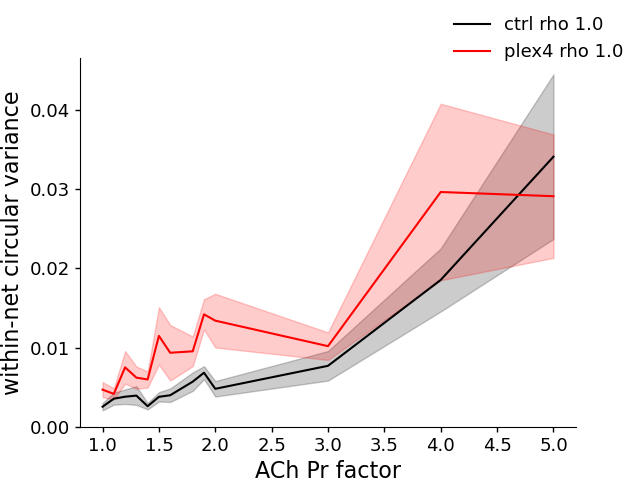

In [34]:
circvar_fig, circvar_ax = plt.subplots(1)
colour_idx = 0
for exp in display_exps:
    for rho in display_rhos:
        circvar_ax.fill_between(
            factors, 
            titration["circvar"][exp][rho]["avg"] + titration["circvar"][exp][rho][err_key],
            titration["circvar"][exp][rho]["avg"] - titration["circvar"][exp][rho][err_key],
            color=colours[colour_idx],
            alpha=0.2,
            hatch=rho_hatches[rho]
        )
        circvar_ax.plot(
            factors,
            titration["circvar"][exp][rho]["avg"],
            color=colours[colour_idx],
            linestyle=rho_linestyles[rho],
            label="%s rho %s" % (exp, str(rho)),
        )
        if rho_colour_mode:
            colour_idx += 1
    if not rho_colour_mode:
        colour_idx += 1
        
circvar_ax.set_ylabel("within-net circular variance", fontsize=16)
circvar_ax.set_xlabel(factor_xlbl, fontsize=16)

circvar_fig.legend(frameon=False, fontsize=13)
clean_axes(circvar_ax, ticksize=13)

exps_lbl = "_".join(display_exps)
rhos_lbl = "_".join(map(str, display_rhos)).replace(".", "p")
rate_lbl = "_peakrate" if rate_mode else "" 
for ext in exts:
    circvar_fig.savefig(
        os.path.join(fig_path, "within-net_circvar_%s_titration_%s_rhos_%s%s%s" % (
            titration_mode, exps_lbl, rhos_lbl, rate_lbl, ext)))

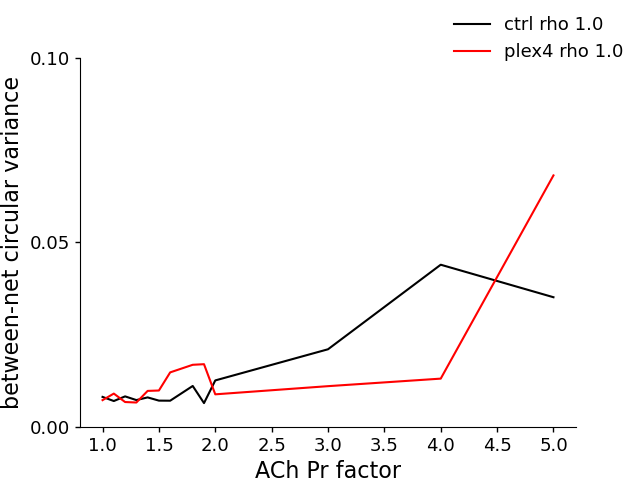

In [35]:
net_circvar_fig, net_circvar_ax = plt.subplots(1)
colour_idx = 0
for exp in display_exps:
    for rho in display_rhos:
        net_circvar_ax.plot(
            factors,
            titration["theta"][exp][rho]["net_circvar"],
            color=colours[colour_idx],
            linestyle=rho_linestyles[rho],
            label="%s rho %s" % (exp, str(rho)),
        )
        if rho_colour_mode:
            colour_idx += 1
    if not rho_colour_mode:
        colour_idx += 1
        
if titration_mode == "gaba":
    net_circvar_ax.set_ylim(0., 0.6)
    net_circvar_ax.set_yticks([0, 0.3, 0.6])
elif titration_mode == "ach":
    net_circvar_ax.set_ylim(0., 0.1)
    net_circvar_ax.set_yticks([0, 0.05, 0.1])

net_circvar_ax.set_ylabel("between-net circular variance", fontsize=16)
net_circvar_ax.set_xlabel(factor_xlbl, fontsize=16)
net_circvar_fig.legend(frameon=False, fontsize=13)
clean_axes(net_circvar_ax, ticksize=13)

exps_lbl = "_".join(display_exps)
rhos_lbl = "_".join(map(str, display_rhos)).replace(".", "p")
rate_lbl = "_peakrate" if rate_mode else "" 
for ext in exts:
    net_circvar_fig.savefig(
        os.path.join(fig_path, "between-net_circvar_%s_titration_%s_rhos_%s%s%s" % (
            titration_mode, exps_lbl, rhos_lbl, rate_lbl, ext)))

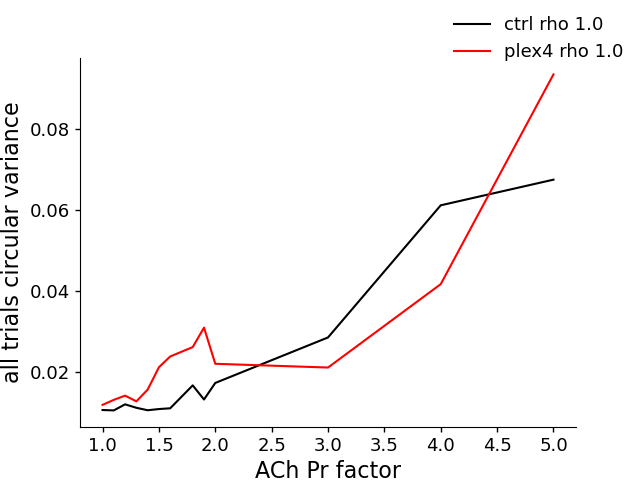

In [37]:
all_circvar_fig, all_circvar_ax = plt.subplots(1)
colour_idx = 0
for exp in display_exps:
    for rho in display_rhos:
        all_circvar_ax.plot(
            factors,
            titration["theta"][exp][rho]["all_circvar"],
            color=colours[colour_idx],
            linestyle=rho_linestyles[rho],
            label="%s rho %s" % (exp, str(rho)),
        )
        if rho_colour_mode:
            colour_idx += 1
    if not rho_colour_mode:
        colour_idx += 1
        
all_circvar_ax.set_ylabel("all trials circular variance", fontsize=16)
all_circvar_ax.set_xlabel(factor_xlbl, fontsize=16)

all_circvar_fig.legend(frameon=False, fontsize=13)
clean_axes(all_circvar_ax, ticksize=13)

exps_lbl = "_".join(display_exps)
rhos_lbl = "_".join(map(str, display_rhos)).replace(".", "p")
rate_lbl = "_peakrate" if rate_mode else "" 
for ext in exts:
    all_circvar_fig.savefig(
        os.path.join(fig_path, "all-trials_circvar_%s_titration_%s_rhos_%s%s%s" % (
            titration_mode, exps_lbl, rhos_lbl, rate_lbl, ext)))

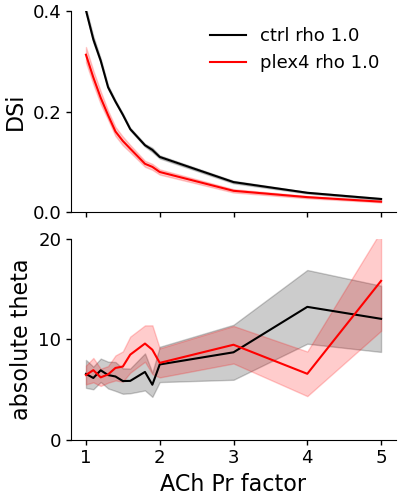

In [38]:
abs_key = "absnettheta"  # absolute value of signed net avgs
dsi_abstheta_fig, dsi_abstheta_ax = plt.subplots(2, sharex=True, figsize=(4, 5))
colour_idx = 0
for exp in display_exps:
    for rho in display_rhos:
        dsi_abstheta_ax[0].fill_between(
            factors, 
            titration["dsi"][exp][rho]["avg"] + titration["dsi"][exp][rho][err_key],
            titration["dsi"][exp][rho]["avg"] - titration["dsi"][exp][rho][err_key],
            color=colours[colour_idx],
            alpha=0.2,
            hatch=rho_hatches[rho]
        )
        dsi_abstheta_ax[0].plot(
            factors,
            titration["dsi"][exp][rho]["avg"],
            color=colours[colour_idx],
            linestyle=rho_linestyles[rho],
            label="%s rho %s" % (exp, str(rho)),
        )
        dsi_abstheta_ax[1].fill_between(
            factors, 
            titration[abs_key][exp][rho]["avg"] + titration[abs_key][exp][rho][err_key],
            titration[abs_key][exp][rho]["avg"] - titration[abs_key][exp][rho][err_key],
            color=colours[colour_idx],
            alpha=0.2,
            hatch=rho_hatches[rho]
        )
        dsi_abstheta_ax[1].plot(
            factors,
            titration[abs_key][exp][rho]["avg"],
            color=colours[colour_idx],
            linestyle=rho_linestyles[rho],
        )
        if rho_colour_mode:
            colour_idx += 1
    if not rho_colour_mode:
        colour_idx += 1
        
        
dsi_abstheta_ax[0].set_ylabel("DSi", fontsize=16)
if titration_mode == "gaba":
    dsi_abstheta_ax[0].set_ylim(0, 0.8)
    dsi_abstheta_ax[0].set_yticks([0, 0.4, 0.8])
    dsi_abstheta_ax[1].set_ylim(0, 30)
    dsi_abstheta_ax[1].set_yticks([0, 15, 30])
elif titration_mode == "ach":
    dsi_abstheta_ax[0].set_ylim(0, 0.4)
    dsi_abstheta_ax[0].set_yticks([0, 0.2, 0.4])
    dsi_abstheta_ax[1].set_ylim(0, 20)
    dsi_abstheta_ax[1].set_yticks([0, 10, 20])

dsi_abstheta_ax[1].set_ylabel("absolute theta", fontsize=16)
dsi_abstheta_ax[1].set_xlabel(factor_xlbl, fontsize=16)

dsi_abstheta_ax[0].legend(frameon=False, fontsize=13)
clean_axes(dsi_abstheta_ax, ticksize=13)
dsi_abstheta_fig.set_layout_engine("constrained")

exps_lbl = "_".join(display_exps)
rhos_lbl = "_".join(map(str, display_rhos)).replace(".", "p")
rate_lbl = "_peakrate" if rate_mode else "" 
for ext in exts:
    dsi_abstheta_fig.savefig(
        os.path.join(fig_path, "dsi_and_abstheta_vs_%s_factor_%s_rhos_%s%s%s" % (
            titration_mode, exps_lbl, rhos_lbl, rate_lbl, ext)),
        bbox_inches="tight",
    )

In [39]:
avg_spikes = {
    exp: {
        fac: {rho: np.mean(nets["spikes"], axis=(0, 1)) for rho, nets in rs.items()}
        for fac, rs in ms.items()
    }
    for exp, ms in metrics.items()
}
std_spikes = {
    exp: {
        fac: {rho: np.std(nets["spikes"], axis=(0, 1)) for rho, nets in rs.items()}
        for fac, rs in ms.items()
    }
    for exp, ms in metrics.items()
}

dirs_180 = np.array([ana.scale_180_from_360(d) for d in  dir_labels])
dir_sort = np.argsort(dirs_180)
dirs_sorted = dir_labels[dir_sort]
dirs_180_sorted = dirs_180[dir_sort]
if np.max(dirs_180) < 180:
    wrap_circ = lambda ds: np.r_[ds, ds[0]]
    circ_180 = np.r_[dirs_180_sorted, -dirs_180_sorted[0]]
else:
    wrap_circ = lambda ds: np.r_[ds[-1], ds] 
    circ_180 = np.r_[-dirs_180_sorted[-1], dirs_180_sorted] 

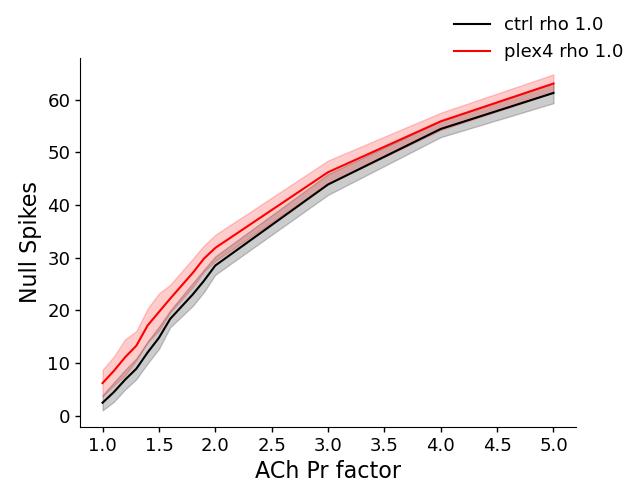

In [40]:
display_angle = 180
angle_idx = np.argwhere(dir_labels == display_angle)[0][0]

dir_focus_fig, dir_focus_ax = plt.subplots(1)
colour_idx = 0
for exp in display_exps:
    for rho in display_rhos:
        spks = np.array([avg_spikes[exp][factor][rho][angle_idx] for factor in factors])
        stds = np.array([std_spikes[exp][factor][rho][angle_idx] for factor in factors])
        lbl = exp if not i else None
        dir_focus_ax.fill_between(
            factors, 
            spks + stds, 
            spks - stds,
            color=colours[colour_idx],
            alpha=0.2,
            hatch=rho_hatches[rho],
        )
        dir_focus_ax.plot(
            factors,
            spks,
            color=colours[colour_idx],
            linestyle=rho_linestyles[rho],
            label="%s rho %s" % (exp, str(rho)),
        )
        if rho_colour_mode:
            colour_idx += 1
    if not rho_colour_mode:
        colour_idx += 1

ylbl = "Null Spikes" if display_angle == 180 else ("Spikes (%i°)" % display_angle)
dir_focus_ax.set_ylabel(ylbl, fontsize=16)
dir_focus_ax.set_xlabel(factor_xlbl, fontsize=16)

dir_focus_fig.legend(frameon=False, fontsize=13)
clean_axes(dir_focus_ax, ticksize=13)

exps_lbl = "_".join(display_exps)
rhos_lbl = "_".join(map(str, display_rhos)).replace(".", "p")
for ext in exts:
    dir_focus_fig.savefig(
        os.path.join(fig_path, "dir_%i_%s_titration_%s_rhos_%s%s" % (
            display_angle, titration_mode, exps_lbl, rhos_lbl, ext)))

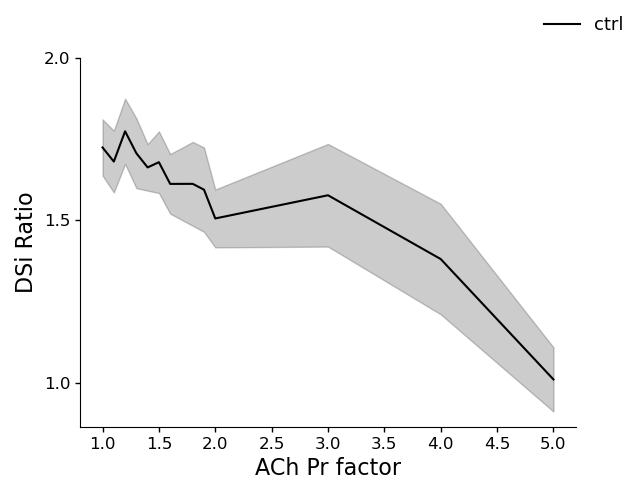

In [41]:
if 1.0 in titration["dsi"][ctrl_lbl] and 0.0 in titration["dsi"][ctrl_lbl]:
    display_exps = exps
    display_exps = ["ctrl" if "ctrl" in exps else exps[0]]
    clrs = ["black", "red", "blue", "green"]
    rho_dsi_effect_fig, rho_dsi_effect_ax = plt.subplots(1)
    rho_dsi_effect_nets = {exp: dsis[1.0]["nets"] / dsis[0.0]["nets"] for exp, dsis in titration["dsi"].items()}
    rho_dsi_effect_avg = {exp: np.mean(nets, axis=0) for exp, nets in rho_dsi_effect_nets.items()}
    rho_dsi_effect_std = {exp: np.std(nets, axis=0) for exp, nets in rho_dsi_effect_nets.items()}
    rho_dsi_effect_sem = {exp: stds / n_sqrt for exp, stds in rho_dsi_effect_std.items()}
    errs = rho_dsi_effect_sem if sem_mode else rho_dsi_effect_std
    
    for exp, clr in zip(display_exps, clrs):
        rho_dsi_effect_ax.fill_between(
            factors, 
            rho_dsi_effect_avg[exp] + errs[exp],
            rho_dsi_effect_avg[exp] - errs[exp],
            color=clr,
            alpha=0.2
        )
        rho_dsi_effect_ax.plot(factors, rho_dsi_effect_avg[exp], c=clr, label=exp)
    
    # rho_dsi_effect_ax.set_yticks([0, 1, 2])
    rho_dsi_effect_ax.set_yticks([1, 1.5, 2])
    # rho_dsi_effect_ax.set_ylabel(r"DSi Ratio ( $\frac{ρ=1}{ρ=0}$ )", fontsize=16)
    rho_dsi_effect_ax.set_ylabel("DSi Ratio", fontsize=16)
    rho_dsi_effect_ax.set_xlabel(factor_xlbl, fontsize=16)
    rho_dsi_effect_fig.legend(frameon=False, fontsize=13)
    
    clean_axes(rho_dsi_effect_ax, ticksize=12)
    exps_lbl = "_".join(display_exps)
    for ext in exts:
        rho_dsi_effect_fig.savefig(
            os.path.join(fig_path, "%s_titration_dsi_effect_of_rho_%s%s" % (
                titration_mode, exps_lbl, ext)), bbox_inches="tight")
else:
    print("Skipped, both corelease (rho 1.0) and completely uncorrelated (rho 0.0) conditions are required.")

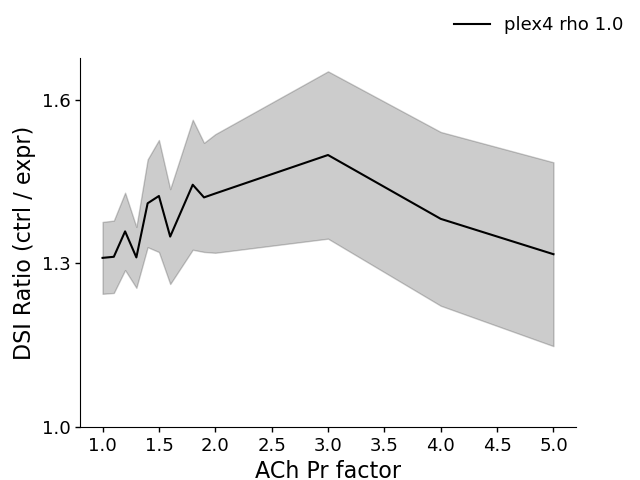

In [21]:
display_denoms = exps[1:]
display_rhos = [1.0]

if len(display_rhos) == 1 and len(display_denoms) == 1:
    colours = ["black"]
elif len(display_rhos) == 2 and len(display_denoms) == 1:
    colours = ["red", "black"]
else:
    colours = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8"]
rho_linestyles = {0.0: "--", 1.0: "-"}
rho_hatches = {0.0: "o", 1.0: None}

exp_dsi_effect_fig, exp_dsi_effect_ax = plt.subplots(1)
exp_dsi_effect_nets = {
    exp: {
        rho: titration["dsi"][ctrl_lbl][rho]["nets"] / titration["dsi"][exp][rho]["nets"] 
        for rho in rhos
    }
    for exp in display_denoms
}
# exp_dsi_effect_avg = {rho: np.mean(nets, axis=0) for rho, nets in exp_dsi_effect_nets.items()}
# exp_dsi_effect_avg = {rho: np.mean(nets, axis=0) for rho, nets in exp_dsi_effect_nets.items()}
exp_dsi_effect_avg = map_data(lambda nets: np.mean(nets, axis=0), exp_dsi_effect_nets)
exp_dsi_effect_std = map_data(lambda nets: np.std(nets, axis=0), exp_dsi_effect_nets)
exp_dsi_effect_sem = map_data(lambda stds: stds / n_sqrt, exp_dsi_effect_std)
errs = exp_dsi_effect_sem if sem_mode else exp_dsi_effect_std

for exp, clr in zip(display_denoms, colours):
    for rho in display_rhos:
        exp_dsi_effect_ax.fill_between(
            factors, 
            exp_dsi_effect_avg[exp][rho] + errs[exp][rho],
            exp_dsi_effect_avg[exp][rho] - errs[exp][rho],
            color=clr,
            linestyle=rho_linestyles[rho],
            hatch=rho_hatches[rho],
            alpha=0.2,
        )
        exp_dsi_effect_ax.plot(
            factors, 
            exp_dsi_effect_avg[exp][rho],
            c=clr,
            linestyle=rho_linestyles[rho],
            label="%s rho %s" % (exp, str(rho)),
        )

# exp_dsi_effect_ax.set_yticks([0, 1, 2])
if display_denoms == ["plex4"]:
    exp_dsi_effect_ax.set_yticks([1, 1.3, 1.6])
exp_dsi_effect_ax.set_ylabel("DSI Ratio (ctrl / expr)", fontsize=16)
exp_dsi_effect_ax.set_xlabel(factor_xlbl, fontsize=16)
# exp_dsi_effect_ax.set_xscale("log")
exp_dsi_effect_fig.legend(frameon=False, fontsize=13)

clean_axes(exp_dsi_effect_ax, ticksize=13)

denoms_lbl = "_".join(display_denoms)
rhos_lbl = "_".join(map(str, display_rhos)).replace(".", "p")
rate_lbl = "_peakrate" if rate_mode else "" 
for ext in exts:
    exp_dsi_effect_fig.savefig(
        os.path.join(fig_path, "%s_titration_dsi_effect_of_exps_%s_rhos_%s%s%s" % (
            titration_mode, exps_lbl, rhos_lbl, rate_lbl, ext)),
        bbox_inches="tight")

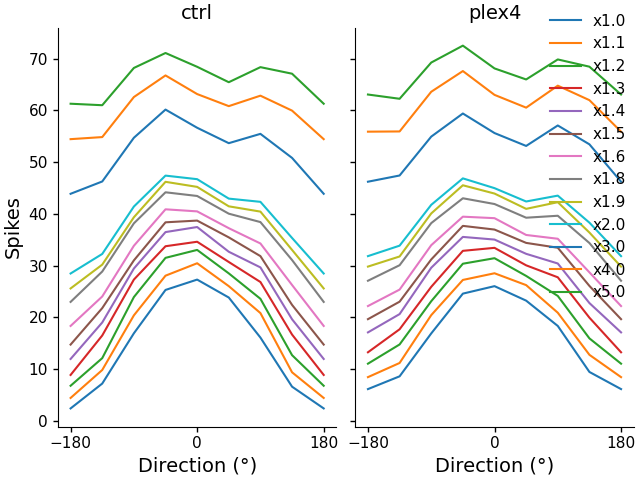

In [22]:
display_exps = exps
# display_exps = ["ctrl", "plex4"]
rho = 1.0

tuning_fig, tuning_ax = plt.subplots(1, len(display_exps), sharey=True)
tuning_ax = [tuning_ax] if display_exps == 1 else tuning_ax
for i, (ax, exp) in enumerate(zip(tuning_ax, display_exps)):
    ax.set_xlabel("Direction (°)", fontsize=14)
    ax.set_title(exp, fontsize=14)
    for factor in factors:
        lbl = ("x" + str(factor)) if not i else None
        ax.plot(circ_180, wrap_circ(avg_spikes[exp][factor][rho][dir_sort]), label=lbl)
    ax.set_xticks([-180, 0, 180])
tuning_ax[0].set_ylabel("Spikes", fontsize=14)
tuning_fig.legend(frameon=False, fontsize=11)
clean_axes(tuning_ax)
tuning_fig.set_layout_engine("compressed")

exps_lbl = "_".join(display_exps)
rho_lbl = str(rho) 
for ext in exts:
    tuning_fig.savefig(
        os.path.join(fig_path, "%s_titration_tuning_%s_rho%s%s" % (titration_mode, exps_lbl, rho_lbl, ext)),
        bbox_inches="tight")

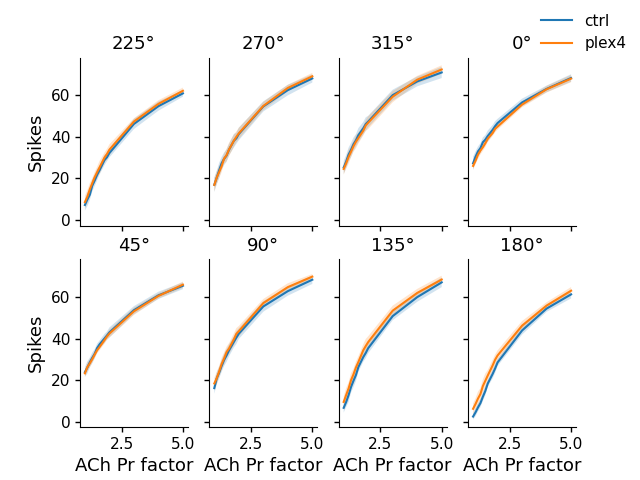

In [23]:
display_exps = exps
# display_exps = ["ctrl", "plex4"]
rho = 1.0

dir_grid_fig, dir_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

i = 0
for row in dir_grid_ax:
    row[0].set_ylabel("Spikes", fontsize=13)
    for ax in row:
        for exp in display_exps:
            spks = np.array([avg_spikes[exp][factor][rho][i] for factor in factors])
            stds = np.array([std_spikes[exp][factor][rho][i] for factor in factors])
            lbl = exp if not i else None
            ax.fill_between(factors, spks + stds, spks - stds, alpha=0.2)
            ax.plot(factors, spks, label=lbl)
            ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in dir_grid_ax.T:
    col[-1].set_xlabel(factor_xlbl, fontsize=13)

# dir_grid_ax[0, 0].invert_xaxis()
# dir_grid_ax[0, 0].set_xscale("log")
dir_grid_fig.legend(frameon=False, fontsize=11)
clean_axes(dir_grid_ax)

exps_lbl = "_".join(display_exps)
rho_lbl = str(rho) 
for ext in exts:
    dir_grid_fig.savefig(
        os.path.join(fig_path, "%s_titration_dir_spikes_grid_%s_rho%s%s" % (
            titration_mode, exps_lbl, rho_lbl, ext)),
        bbox_inches="tight")

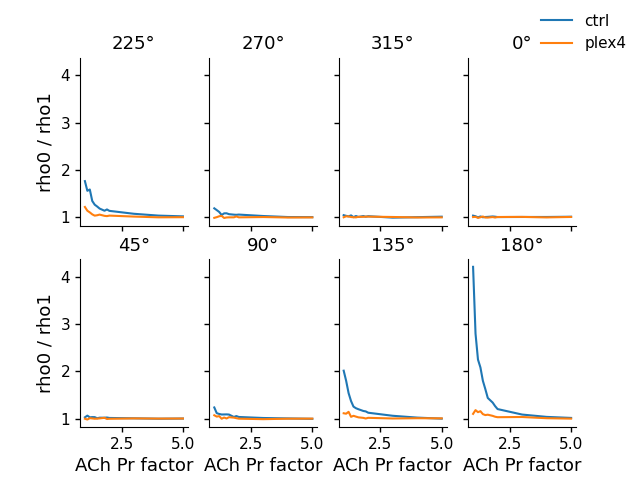

In [24]:
display_exps = exps
# display_exps = ["ctrl", "plex4"]

dir_rho_mult_grid_fig, dir_rho_mult_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

i = 0
for row in dir_rho_mult_grid_ax:
    row[0].set_ylabel("rho0 / rho1", fontsize=13)
    for ax in row:
        for exp in display_exps:
            rho0_spks = np.array([avg_spikes[exp][factor][0.0][i] for factor in factors])
            rho1_spks = np.array([avg_spikes[exp][factor][1.0][i] for factor in factors])
            lbl = exp if not i else None
            ax.plot(factors, rho0_spks / rho1_spks, label=lbl)
            ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in dir_rho_mult_grid_ax.T:
    col[-1].set_xlabel(factor_xlbl, fontsize=13)
        
dir_rho_mult_grid_fig.legend(frameon=False, fontsize=11)
clean_axes(dir_rho_mult_grid_ax)

exps_lbl = "_".join(display_exps)
rho_lbl = str(rho) 
for ext in exts:
    dir_rho_mult_grid_fig.savefig(
        os.path.join(fig_path, "%s_titration_dir_spikes_effect_of_rho_grid_%s%s" % (
            titration_mode, exps_lbl, ext)),
        bbox_inches="tight")

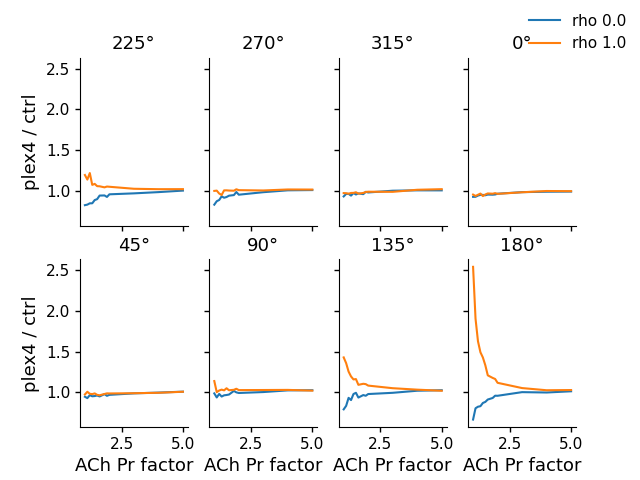

In [25]:
dir_exp_mult_grid_fig, dir_exp_mult_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

i = 0
for row in dir_exp_mult_grid_ax:
    row[0].set_ylabel("%s / %s" % (expr_lbl, ctrl_lbl), fontsize=13)
    for ax in row:
        for rho in rhos:
            ctrl_spks = np.array([avg_spikes[ctrl_lbl][factor][rho][i] for factor in factors])
            expr_spks = np.array([avg_spikes[expr_lbl][factor][rho][i] for factor in factors])
            lbl = ("rho " + str(rho)) if not i else None
            ax.plot(factors, expr_spks / ctrl_spks, label=lbl)
            ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in dir_exp_mult_grid_ax.T:
    col[-1].set_xlabel(factor_xlbl, fontsize=13)
        
dir_exp_mult_grid_fig.legend(frameon=False, fontsize=11)
clean_axes(dir_exp_mult_grid_ax)
for ext in exts:
    dir_exp_mult_grid_fig.savefig(
        os.path.join(fig_path, "%s_titration_dir_spikes_effect_of_exp_grid%s" % (titration_mode, ext)),
        bbox_inches="tight")

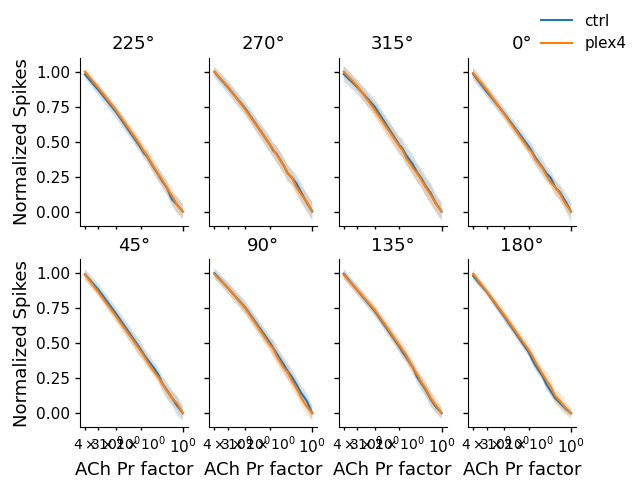

In [26]:
rho = 1.0
norm_dir_grid_fig, norm_dir_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

norm_dir_spikes, norm_dir_stds = {}, {}
for exp in exps:
    norm_dir_spikes[exp] = []
    norm_dir_stds[exp] = []
    for i in range(len(dir_labels)):
        spks = np.stack([[avg_spikes[exp][factor][rho][i] for factor in factors] for rho in rhos], axis=0)
        stds = np.stack([[std_spikes[exp][factor][rho][i] for factor in factors] for rho in rhos], axis=0)
        min_spks = np.min(spks)
        max_spks = np.max(spks)
        spks = (spks - min_spks) / (max_spks - min_spks)
        stds = stds / (max_spks - min_spks)
        norm_dir_spikes[exp].append(spks)
        norm_dir_stds[exp].append(stds)
norm_dir_spikes = {exp: np.stack(spks, axis=0) for exp, spks in norm_dir_spikes.items()}
norm_dir_stds = {exp: np.stack(stds, axis=0) for exp, stds in norm_dir_stds.items()}
    
i = 0
j = np.argwhere(np.array(rhos) == rho)[0][0]
for row in norm_dir_grid_ax:
    row[0].set_ylabel("Normalized Spikes", fontsize=13)
    for ax in row:
        for exp in exps:
            lbl = exp if not i else None
            spks = norm_dir_spikes[exp][i, j]
            stds = norm_dir_stds[exp][i, j]
            ax.fill_between(factors, spks + stds, spks - stds, alpha=0.2)
            ax.plot(factors, spks, label=lbl)
            ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in norm_dir_grid_ax.T:
    col[-1].set_xlabel(factor_xlbl, fontsize=13)
        
norm_dir_grid_ax[0, 0].set_ylim(-0.1, 1.1)
norm_dir_grid_ax[0, 0].invert_xaxis()
norm_dir_grid_ax[0, 0].set_xscale("log")
norm_dir_grid_fig.legend(frameon=False, fontsize=11)
clean_axes(norm_dir_grid_ax)
for ext in exts:
    norm_dir_grid_fig.savefig(
        os.path.join(fig_path, "%s_titration_norm_dir_spikes_grid%s" % (titration_mode, ext)),
        bbox_inches="tight")

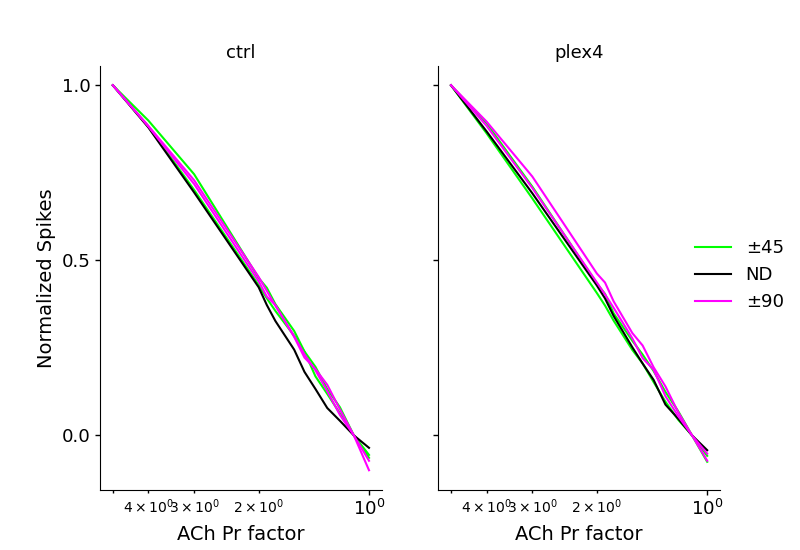

In [27]:
rho = 1.0
fctrs = factors[:]
# fctrs = factors[4:]
norm_rho_dir_spikes, norm_rho_dir_stds = {}, {}
for exp in exps:
    norm_rho_dir_spikes[exp] = []
    norm_rho_dir_stds[exp] = []
    for i in range(len(dir_labels)):
        spks = np.stack([[avg_spikes[exp][factor][rho][i] for factor in fctrs] for rho in rhos], axis=0)
        stds = np.stack([[std_spikes[exp][factor][rho][i] for factor in fctrs] for rho in rhos], axis=0)
        # if gaba factor x0.0 is included, lines will not reach spiking=1 on the log plot
        min_spks = np.min(spks[:, 1:], axis=1, keepdims=True) 
        max_spks = np.max(spks[:, 1:], axis=1, keepdims=True)
        spks = (spks - min_spks) / (max_spks - min_spks)
        stds = stds / (max_spks - min_spks)
        norm_rho_dir_spikes[exp].append(spks)
        norm_rho_dir_stds[exp].append(stds)
norm_rho_dir_spikes = {exp: np.stack(spks, axis=0) for exp, spks in norm_rho_dir_spikes.items()}
norm_rho_dir_stds = {exp: np.stack(stds, axis=0) for exp, spks in norm_rho_dir_stds.items()}

r = np.argwhere(np.array(rhos) == rho)[0][0]
log_titration_fig, log_titration_ax = plt.subplots(1, len(exps), sharex=True, sharey=True, figsize=(8, 5.5))
for i, (exp, ax) in enumerate(zip(exps, log_titration_ax)):
    ax.plot(fctrs, norm_rho_dir_spikes[exp][2, r], label="±45" if i else None, c="lime")  # 45
    ax.plot(fctrs, norm_rho_dir_spikes[exp][4, r], c="lime")  # 315
    # ax.fill_between(
    #     fctrs, 
    #     norm_rho_dir_spikes[exp][7, r] + norm_rho_dir_stds[exp][7, r],
    #     norm_rho_dir_spikes[exp][7, r] - norm_rho_dir_stds[exp][7, r],
    #     alpha=0.2, color="black"
    # )
    ax.plot(fctrs, norm_rho_dir_spikes[exp][7, r], label="ND" if i else None, c="black")  # 180
    ax.plot(fctrs, norm_rho_dir_spikes[exp][1, r], label="±90" if i else None, c="magenta")  # 270
    ax.plot(fctrs, norm_rho_dir_spikes[exp][5, r], c="magenta")  # 90
    ax.set_title(exp, fontsize=13)
    ax.set_xlabel(factor_xlbl, fontsize=14)

# from matplotlib.scale import LogScale
log_titration_ax[0].set_yticks([0, 0.5, 1.0])
log_titration_ax[0].set_ylabel("Normalized Spikes", fontsize=14)
log_titration_ax[0].invert_xaxis()
log_titration_ax[0].set_xscale("log")
log_titration_fig.legend(frameon=False, loc="right", fontsize=13)
clean_axes(log_titration_ax, ticksize=13)
for ext in exts:
    log_titration_fig.savefig(
        os.path.join(fig_path, "log_%s_titration%s" % (titration_mode, ext)), bbox_inches="tight")

In [28]:
avg_spike_mats = {
    exp: {
        rho: np.stack(
            [wrap_circ(avg_spikes[exp][factor][rho][dir_sort]) for factor in factors], axis=0)
        for rho in rhos
    }
    for exp in exps
}
avg_max_spikes = np.max([m.max() for mats in avg_spike_mats.values() for m in mats.values()])

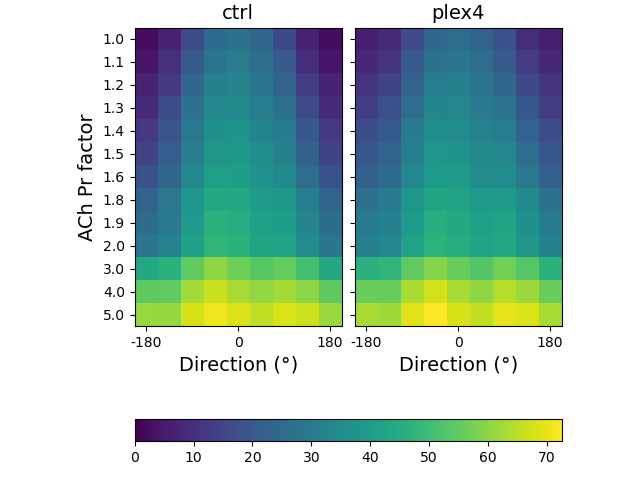

In [29]:
display_exps = exps
# display_exps = ["ctrl", "plex4"]
rho = 1.0
vmax = avg_max_spikes
# vmax = 20.0

tuning_mat_fig, tuning_mat_ax = plt.subplots(1, len(display_exps), sharey=True)
tuning_mat_ax = [tuning_mat_ax] if len(display_exps) == 1 else tuning_mat_ax
avg_spike_imgs = {}
for i, (ax, exp) in enumerate(zip(tuning_mat_ax, display_exps)):
    ax.set_xlabel("Direction (°)", fontsize=14)
    ax.set_title(exp, fontsize=14)
    avg_spike_imgs[exp] = ax.imshow(avg_spike_mats[exp][rho], vmin=0, vmax=vmax, cmap="viridis")
    ax.set_xticks([0, 4, 8])
    ax.set_xticklabels([-180, 0, 180])
    ax.set_yticks(range(len(factors)))
    ax.set_yticklabels(factors)
    
tuning_mat_ax[0].set_ylabel(factor_xlbl, fontsize=14)
tuning_mat_fig.colorbar(
    avg_spike_imgs[display_exps[-1]], ax=tuning_mat_ax, orientation="horizontal")
tuning_mat_fig.set_layout_engine("compressed")

exps_lbl = "_".join(display_exps)
rho_lbl = str(rho) 
for ext in exts:
    tuning_mat_fig.savefig(
        os.path.join(fig_path, "%s_titration_tuning_matrices_%s_rho%s%s" % (
            titration_mode, exps_lbl, rho_lbl, ext)),
        bbox_inches="tight")

In [30]:
close_button()